In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
models = ["gpt-4o", "gpt-4o-mini", "llama3.1-8b-instruct-q4_0"]
setting = [""]
results_path = "../results/llms"
ground_truth_path = "../results/ground_truth.csv"

In [3]:
def update_unsat_results(df, ground_truth_df):
    labels = []
    for i, row in df.iterrows():
        if row["result"] == "UNSAT" or row.get("status") == "unsat":
            labels.append(int(ground_truth_df.loc[i]["status"] == "unsat"))
        else:
            labels.append(row["valid?"])

    df["valid?"] = labels
    return df


def get_result(df, ground_truth_df):
    df["label"] = ground_truth_df["status"]
    df_sat = df[df["label"] != "unsat"]
    df_unsat = df[df["label"] == "unsat"]
    if "status" in df.columns:
        df_predicted_unsat = df[df["status"] == "unsat"]
        df_predicted_sat = df[df["status"] == "sat"]
    else:
        df_predicted_unsat = df[df["result"] == "UNSAT"]
        df_predicted_sat = df[df["result"] != "UNSAT"]

    generation_success_rate = df_sat["valid?"].sum() / len(df_sat)

    unsat_recall = df_unsat["valid?"].sum() / len(df_unsat) if len(df_unsat) > 0 else 1
    unsat_precision = (
        df_predicted_unsat["valid?"].sum() / len(df_predicted_unsat)
        if len(df_predicted_unsat) > 0
        else 1
    )
    unsat_f1 = (
        2 * unsat_precision * unsat_recall / (unsat_precision + unsat_recall)
        if unsat_precision + unsat_recall > 0
        else 0
    )
    return {
        "generation_success_rate": generation_success_rate,
        "unsat_recall": unsat_recall,
        "unsat_precision": unsat_precision,
        "unsat_f1": unsat_f1,
    }


def get_results_case_wise(df, ground_truth_df):
    names = df["name"].unique()
    results = []

    for name in names:
        df_case = df[df["name"] == name].copy()
        gt_df_case = ground_truth_df[ground_truth_df["name"] == name].copy()
        results.append(get_result(df_case, gt_df_case))

    metrics = results[0].keys()
    avg_results = {
        metric: np.mean([result[metric] for result in results]) for metric in metrics
    }

    return avg_results

In [4]:
ground_truth = pd.read_csv(ground_truth_path)

# # load results
# result_path = os.path.join(results_path, "run1")
# results = {}
# for model in models:
#     for s in setting:
#         result_file = os.path.join(result_path, f"{model}{s}_validation.csv")
#         df = pd.read_csv(result_file)
#         df = update_unsat_results(df, ground_truth)
#         results[f"{model}{s}"] = df

In [5]:
from loguru import logger
input_folder = "../results/generation_with_gt"

llms = ["gpt-4o-mini", "gpt-4o", "deepseek-chat", "llama3.1-8b"]
approaches = ["explanation", "feedback", "validation"]
checkers = ["python", "smt", "hybrid"]

results = {}

for llm in llms:
    for approach in approaches:
        for check in checkers:
            result_file = f"{input_folder}/{approach}/{check}/{llm}.csv_validation.csv"
            if not os.path.exists(result_file):
                logger.warning(f"Config {llm}_{approach}_{check} does not exist")
                continue
            df = pd.read_csv(result_file)
            df = update_unsat_results(df, ground_truth)
            results[f"{llm}_{approach}_{check}"] = df


In [6]:
llm_folder = "../results/generation"

for llm in llms:
    result_file = f"{llm_folder}/{llm}.csv_validation.csv"
    
    if not os.path.exists(result_file):
        logger.warning(f"Config {llm} does not exist")
        continue

    df = pd.read_csv(result_file)
    df = update_unsat_results(df, ground_truth)
    results[f"{llm}"] = df

In [7]:
accuracy = {}

# calculate accuracy
# for model in models:
#     for s in setting:
for key in results.keys():
        result = results[key]
        accuracy[key] = get_result(result, ground_truth)

In [8]:
get_results_case_wise(result, ground_truth)

{'generation_success_rate': 0.32946570118949153,
 'unsat_recall': 0.6458333333333334,
 'unsat_precision': 0.32142857142857145,
 'unsat_f1': 0.3026315789473684}

In [9]:
summarized_results = []
for key, value in accuracy.items():
    value["approach"] = key
    summarized_results.append(value)

summarized_results = pd.DataFrame(summarized_results)
summarized_results.set_index("approach", inplace=True)
summarized_results = (summarized_results * 100).round(2)
summarized_results = summarized_results[["generation_success_rate", "unsat_precision", "unsat_recall", "unsat_f1"]]
print(summarized_results.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
 & generation_success_rate & unsat_precision & unsat_recall & unsat_f1 \\
approach &  &  &  &  \\
\midrule
gpt-4o-mini_explanation_python & 74.56 & 52.31 & 59.65 & 55.74 \\
gpt-4o-mini_explanation_smt & 74.56 & 69.33 & 91.23 & 78.79 \\
gpt-4o-mini_explanation_hybrid & 77.74 & 74.29 & 92.98 & 82.59 \\
gpt-4o-mini_feedback_python & 71.38 & 50.77 & 57.89 & 54.10 \\
gpt-4o-mini_feedback_smt & 75.97 & 65.82 & 91.23 & 76.47 \\
gpt-4o-mini_feedback_hybrid & 78.09 & 72.00 & 94.74 & 81.82 \\
gpt-4o-mini_validation_python & 73.50 & 47.37 & 63.16 & 54.14 \\
gpt-4o-mini_validation_smt & 74.20 & 60.56 & 75.44 & 67.19 \\
gpt-4o-mini_validation_hybrid & 77.39 & 63.08 & 71.93 & 67.21 \\
gpt-4o_explanation_python & 91.52 & 90.62 & 50.88 & 65.17 \\
gpt-4o_explanation_smt & 89.75 & 81.54 & 92.98 & 86.89 \\
gpt-4o_explanation_hybrid & 92.23 & 96.36 & 92.98 & 94.64 \\
gpt-4o_feedback_python & 90.81 & 96.67 & 52.63 & 68.16 \\
gpt-4o_feedback_smt & 87.28 & 82.26 & 89.47 & 85.7

In [10]:
summarized_results

,generation_success_rate,unsat_precision,unsat_recall,unsat_f1
approach,,,,
gpt-4o-mini_explanation_python,74.56,52.31,59.65,55.74
gpt-4o-mini_explanation_smt,74.56,69.33,91.23,78.79
gpt-4o-mini_explanation_hybrid,77.74,74.29,92.98,82.59
gpt-4o-mini_feedback_python,71.38,50.77,57.89,54.10
gpt-4o-mini_feedback_smt,75.97,65.82,91.23,76.47
gpt-4o-mini_feedback_hybrid,78.09,72.00,94.74,81.82
gpt-4o-mini_validation_python,73.50,47.37,63.16,54.14
gpt-4o-mini_validation_smt,74.20,60.56,75.44,67.19
gpt-4o-mini_validation_hybrid,77.39,63.08,71.93,67.21


## Constraint Generation

In [11]:
import pandas as pd

In [12]:
folder_path = "../results/constraint_generation_results.csv"
df = pd.read_csv(folder_path)

In [13]:
total_results = df["total_results"][0]

In [14]:
smt_df = df[df["generator_type"] == "smt"]
smt_df[smt_df.select_dtypes(include=['number']).columns] = smt_df.select_dtypes(include=['number']) / total_results


C:\Users\chenp\AppData\Local\Temp\ipykernel_39364\805623670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smt_df[smt_df.select_dtypes(include=['number']).columns] = smt_df.select_dtypes(include=['number']) / total_results


In [15]:
smt_df

,generator_type,generator_mode,model_name,total_results,generation_success,validation_success,formal_verification_success
8,smt,batch,Meta-Llama-3.1-8B-Instruct-Turbo-128K,1.0,0.019231,0.019231,0.019231
9,smt,batch,deepseek-chat,1.0,0.798077,0.778846,0.673077
10,smt,batch,gpt-4o,1.0,0.855769,0.721154,0.625000
11,smt,batch,gpt-4o-mini,1.0,0.413462,0.365385,0.346154
12,smt,independent,Meta-Llama-3.1-8B-Instruct-Turbo-128K,1.0,0.173077,0.125000,0.115385
13,smt,independent,deepseek-chat,1.0,0.855769,0.788462,0.682692
14,smt,independent,gpt-4o,1.0,0.865385,0.750000,0.673077
15,smt,independent,gpt-4o-mini,1.0,0.625000,0.490385,0.442308


In [16]:
smt_df["formal_verification_success"] / smt_df["generation_success"]

8     1.000000
9     0.843373
10    0.730337
11    0.837209
12    0.666667
13    0.797753
14    0.777778
15    0.707692
dtype: float64

In [17]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('ieee')

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


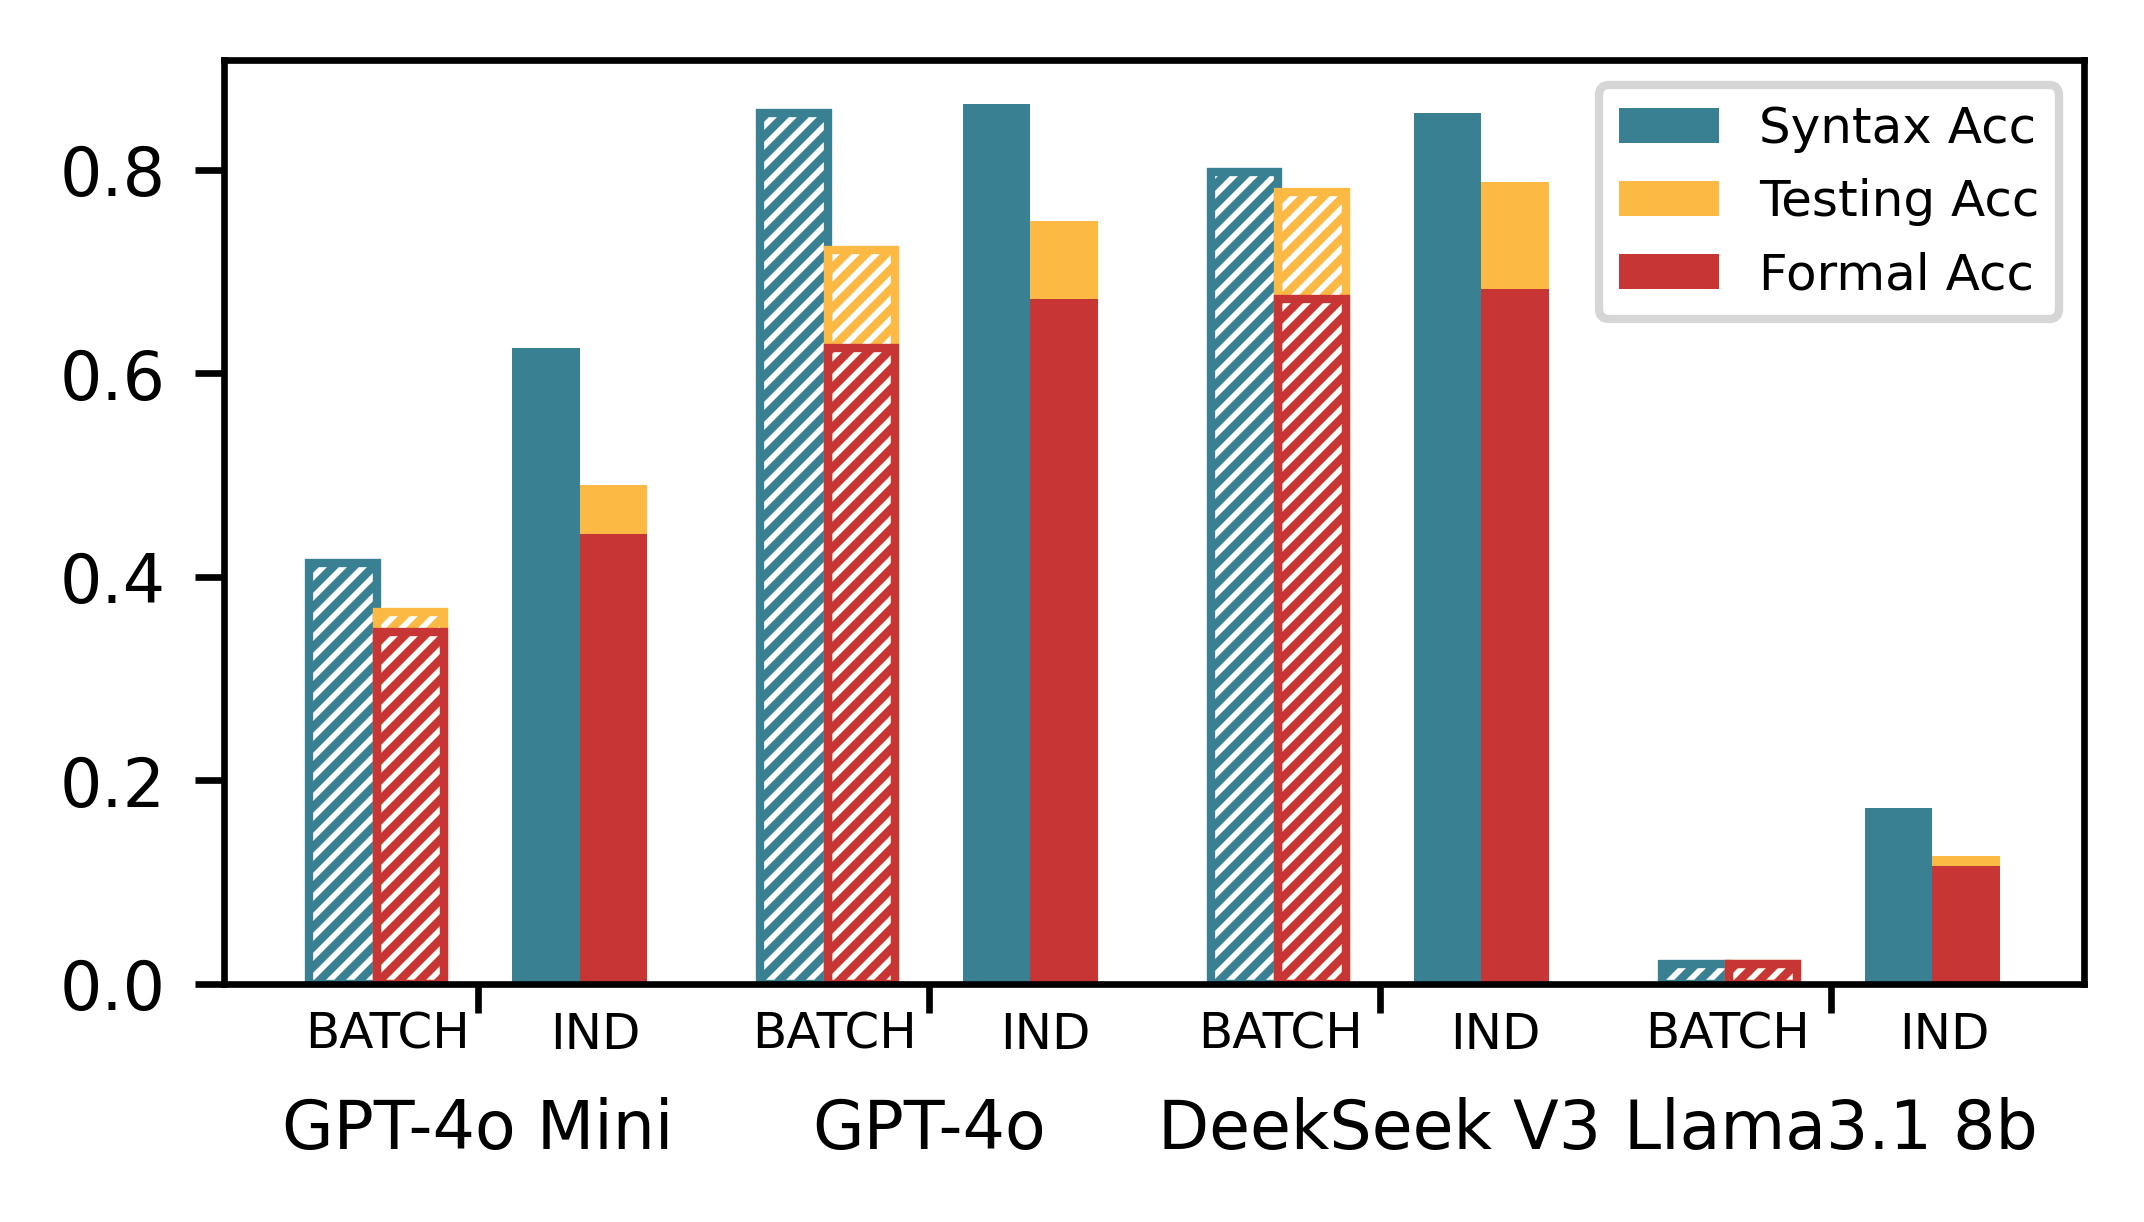

In [18]:
llm_map = {
    "Meta-Llama-3.1-8B-Instruct-Turbo-128K": "Llama3.1 8b",
    "deepseek-chat": "DeekSeek V3",
    "gpt-4o": "GPT-4o",
    "gpt-4o-mini": "GPT-4o Mini"
}

metric_map = {
    "generation_success": "Syntax Acc",
    "validation_success": "Testing Acc",
    "formal_verification_success": "Formal Acc"
}


llms = ["gpt-4o-mini", "gpt-4o", "deepseek-chat", "Meta-Llama-3.1-8B-Instruct-Turbo-128K"]
metrics = ["generation_success", "validation_success", "formal_verification_success"]

# colors = ["#7CBACB", "#FDD58F", "#DE8484"]
colors = ["#3a8093", "#fcb944", "#c73535"]
hatches = ["//////////", "//////////", "//////////"]

x = np.arange(len(llms))
width = 0.15
multiplier = 0
smt_df_independent = smt_df[smt_df["generator_mode"] == "batch"]
smt_df_independent.set_index("model_name", inplace=True)

fig, ax = plt.subplots(figsize=(4, 2))
for i, metric in enumerate(metrics):
    ax.bar(x + width * multiplier, smt_df_independent.loc[llms][metric], width, edgecolor=colors[i], fill=False, hatch=hatches[i])
    if metric == "generation_success":
        multiplier += 1

for i in range (len(llms)):
    pos_x = 6.6 * width * i + 0.1
    pos_y = -0.05
    ax.text(pos_x, pos_y, "BATCH",
            horizontalalignment='center', verticalalignment='center', size=6,
            clip_on=False)

colors = ["#3a8093", "#fcb944", "#c73535"]
smt_df_independent = smt_df[smt_df["generator_mode"] == "independent"]
smt_df_independent.set_index("model_name", inplace=True)
multiplier += 2
# fig, ax = plt.subplots(figsize=(4, 2))
for i, metric in enumerate(metrics):
    ax.bar(x + width * multiplier, smt_df_independent.loc[llms][metric], width, color=colors[i], label=metric_map[metric])
    if metric == "generation_success":
        multiplier += 1


for i in range (len(llms)):
    pos_x = 6.65 * width * i + 0.56
    pos_y = -0.05
    ax.text(pos_x, pos_y, "IND",
            horizontalalignment='center', verticalalignment='center', size=6,
            clip_on=False)
    
# ax.set_title('SMT Constraint Generation')
ax.set_xticks(x + 2 * width, [llm_map[llm] for llm in llms])
ax.xaxis.set_tick_params(pad=10)
ax.legend(loc='upper right', ncols=1,  prop={'size': 6})
plt.savefig("smt_constraint_generation.pdf", bbox_inches='tight')
plt.show()




In [19]:
smt_df_independent 

,generator_type,generator_mode,total_results,generation_success,validation_success,formal_verification_success
model_name,,,,,,
Meta-Llama-3.1-8B-Instruct-Turbo-128K,smt,independent,1.0,0.173077,0.125000,0.115385
deepseek-chat,smt,independent,1.0,0.855769,0.788462,0.682692
gpt-4o,smt,independent,1.0,0.865385,0.750000,0.673077
gpt-4o-mini,smt,independent,1.0,0.625000,0.490385,0.442308


In [20]:
smt_df_batch

NameError: name 'smt_df_batch' is not defined

In [22]:
smt_df_independent.loc[llms, metrics[1]]

model_name
gpt-4o-mini                              0.490385
gpt-4o                                   0.750000
deepseek-chat                            0.788462
Meta-Llama-3.1-8B-Instruct-Turbo-128K    0.125000
Name: validation_success, dtype: float64